In [3]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import geobr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlalchemy as sa

import database as db
from images import get_list_of_images_invalid, select_images
from models import County, DataTrustedIdentifier

In [5]:
engine, session=db.connect()
engine.echo=False

2023-03-31 10:31:08,497 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2023-03-31 10:31:08,498 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-03-31 10:31:08,499 INFO sqlalchemy.engine.Engine select current_schema()
2023-03-31 10:31:08,500 INFO sqlalchemy.engine.Engine [raw sql] {}
2023-03-31 10:31:08,501 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2023-03-31 10:31:08,501 INFO sqlalchemy.engine.Engine [raw sql] {}


In [6]:
geobr.list_geobr()
states = geobr.read_state(year=2020)
regions = geobr.read_region(year=2020)

minimum_image=5
color='rgb'
image_size='256'
list_regions=['Norte', 'Nordeste', 'Sul', 'Sudeste', 'Centro-Oeste']
list_images_invalid=get_list_of_images_invalid()
list_images_invalid=list_images_invalid['barcode']

Function: read_country
Geographies available: Country
Years available: 1872, 1900, 1911, 1920, 1933, 1940, 1950, 1960, 1970, 1980, 1991, 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_region
Geographies available: Region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_state
Geographies available: States
Years available: 1872, 1900, 1911, 1920, 1933, 1940, 1950, 1960, 1970, 1980, 1991, 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_meso_region
Geographies available: Meso region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_micro_region
Geographies available: Micro region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

/home/xandao/miniconda3/lib/python3.9/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/xandao/miniconda3/lib/python3.9/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/xandao/miniconda3/lib/python3.9/site-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/home/xandao/miniconda3/lib/python3.9/site-packages/geopandas/array.py:93: ShapelyDep

## Data of regions

In [7]:
list_level_regions_total = []
list_count_regions_total = []
for region in list_regions:
    query = session.query(County).filter(County.regiao.__eq__(region)).distinct().all()

    state_unaccented_lower, uf_unaccented_lower, county_unaccented_lower = db.get_state_uf_county(query)

    list_level = []
    list_path_images_final = []
    list_seq_final = []
    list_count_samples = []

    level=DataTrustedIdentifier.specific_epithet_trusted
    condition = sa.and_(DataTrustedIdentifier.country_trusted.__eq__('Brasil'), level.is_not(None), sa.or_(uf_unaccented_lower, state_unaccented_lower, county_unaccented_lower))

    query = db.get_records_group_by_level(condition, level, minimum_image, session)
    print('region: %s color: %s image_size: %s minimum_image: %d' % (region, color.upper(), image_size, minimum_image))
    select_images(color, image_size, list_count_samples, list_level, list_images_invalid, list_path_images_final, list_seq_final, minimum_image, session, query)

    total = np.sum([c for c in list_count_samples])
    print('total of images: %d total of levels: %d' % (total, len(list_level)))
    list_level_regions_total.append(len(list_level))
    list_count_regions_total.append(total)

/home/xandao/Documentos/piperaceae-sql/database.py:77: SAWarning: Class unaccent will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/20/cprf)
  query = session.query(*columns) \


region: Norte color: RGB image_size: 256 minimum_image: 5
total of images: 2682 total of levels: 110
region: Nordeste color: RGB image_size: 256 minimum_image: 5
total of images: 1212 total of levels: 52
region: Sul color: RGB image_size: 256 minimum_image: 5
total of images: 2549 total of levels: 79
region: Sudeste color: RGB image_size: 256 minimum_image: 5
total of images: 2851 total of levels: 106
region: Centro-Oeste color: RGB image_size: 256 minimum_image: 5
total of images: 1218 total of levels: 46


In [8]:
regions['level'] = list_level_regions_total
regions['total'] = list_count_regions_total
list_regions[len(list_regions)-1]='Centro Oeste'
list_regions_en = ['North', 'Northeast', 'South', 'Southeast', 'Middlewest']
for r in zip(list_regions, list_regions_en):
    regions['name_region'].replace(r[0], r[1], inplace=True)

## Data of states

In [9]:
query=session.query(County.uf).distinct().all()
list_uf=[s.uf for s in query]
states.sort_values(by=['abbrev_state'], inplace=True)
list_count_states_total=[]
list_level_states_total=[]

In [10]:
for uf in sorted(list_uf):
    query = session.query(County).filter(County.uf.__eq__(uf)).distinct().all()
    state_unaccented_lower, uf_unaccented_lower, county_unaccented_lower = db.get_state_uf_county(query)

    list_level = []
    list_path_images_final = []
    list_seq_final = []
    list_count_samples = []

    level=DataTrustedIdentifier.specific_epithet_trusted
    condition = sa.and_(DataTrustedIdentifier.country_trusted.__eq__('Brasil'), level.is_not(None), sa.or_(uf_unaccented_lower, state_unaccented_lower, county_unaccented_lower))

    query = db.get_records_group_by_level(condition, level, minimum_image, session)
    print('uf: %s color: %s image_size: %s minimum_image: %d' % (uf, color.upper(), image_size, minimum_image))
    select_images(color, image_size, list_count_samples, list_level, list_images_invalid, list_path_images_final, list_seq_final, minimum_image, session, query)

    total = np.sum([c for c in list_count_samples])
    print('total of images: %d total of levels: %d' % (total, len(list_level)))
    list_level_states_total.append(len(list_level))
    list_count_states_total.append(total)

states['level']=list_level_states_total
states['total']=list_count_states_total    

uf: AC color: RGB image_size: 256 minimum_image: 5
total of images: 373 total of levels: 34
uf: AL color: RGB image_size: 256 minimum_image: 5
total of images: 21 total of levels: 2
uf: AM color: RGB image_size: 256 minimum_image: 5
total of images: 1031 total of levels: 61
uf: AP color: RGB image_size: 256 minimum_image: 5
total of images: 61 total of levels: 8
uf: BA color: RGB image_size: 256 minimum_image: 5
total of images: 933 total of levels: 45
uf: CE color: RGB image_size: 256 minimum_image: 5
total of images: 19 total of levels: 3
uf: DF color: RGB image_size: 256 minimum_image: 5
total of images: 373 total of levels: 22
uf: ES color: RGB image_size: 256 minimum_image: 5
total of images: 249 total of levels: 25
uf: GO color: RGB image_size: 256 minimum_image: 5
total of images: 375 total of levels: 17
uf: MA color: RGB image_size: 256 minimum_image: 5
total of images: 28 total of levels: 2
uf: MG color: RGB image_size: 256 minimum_image: 5
total of images: 832 total of levels

/home/xandao/miniconda3/lib/python3.9/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/xandao/miniconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/home/xandao/miniconda3/lib/python3.9/site-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/home/xandao/miniconda3/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work

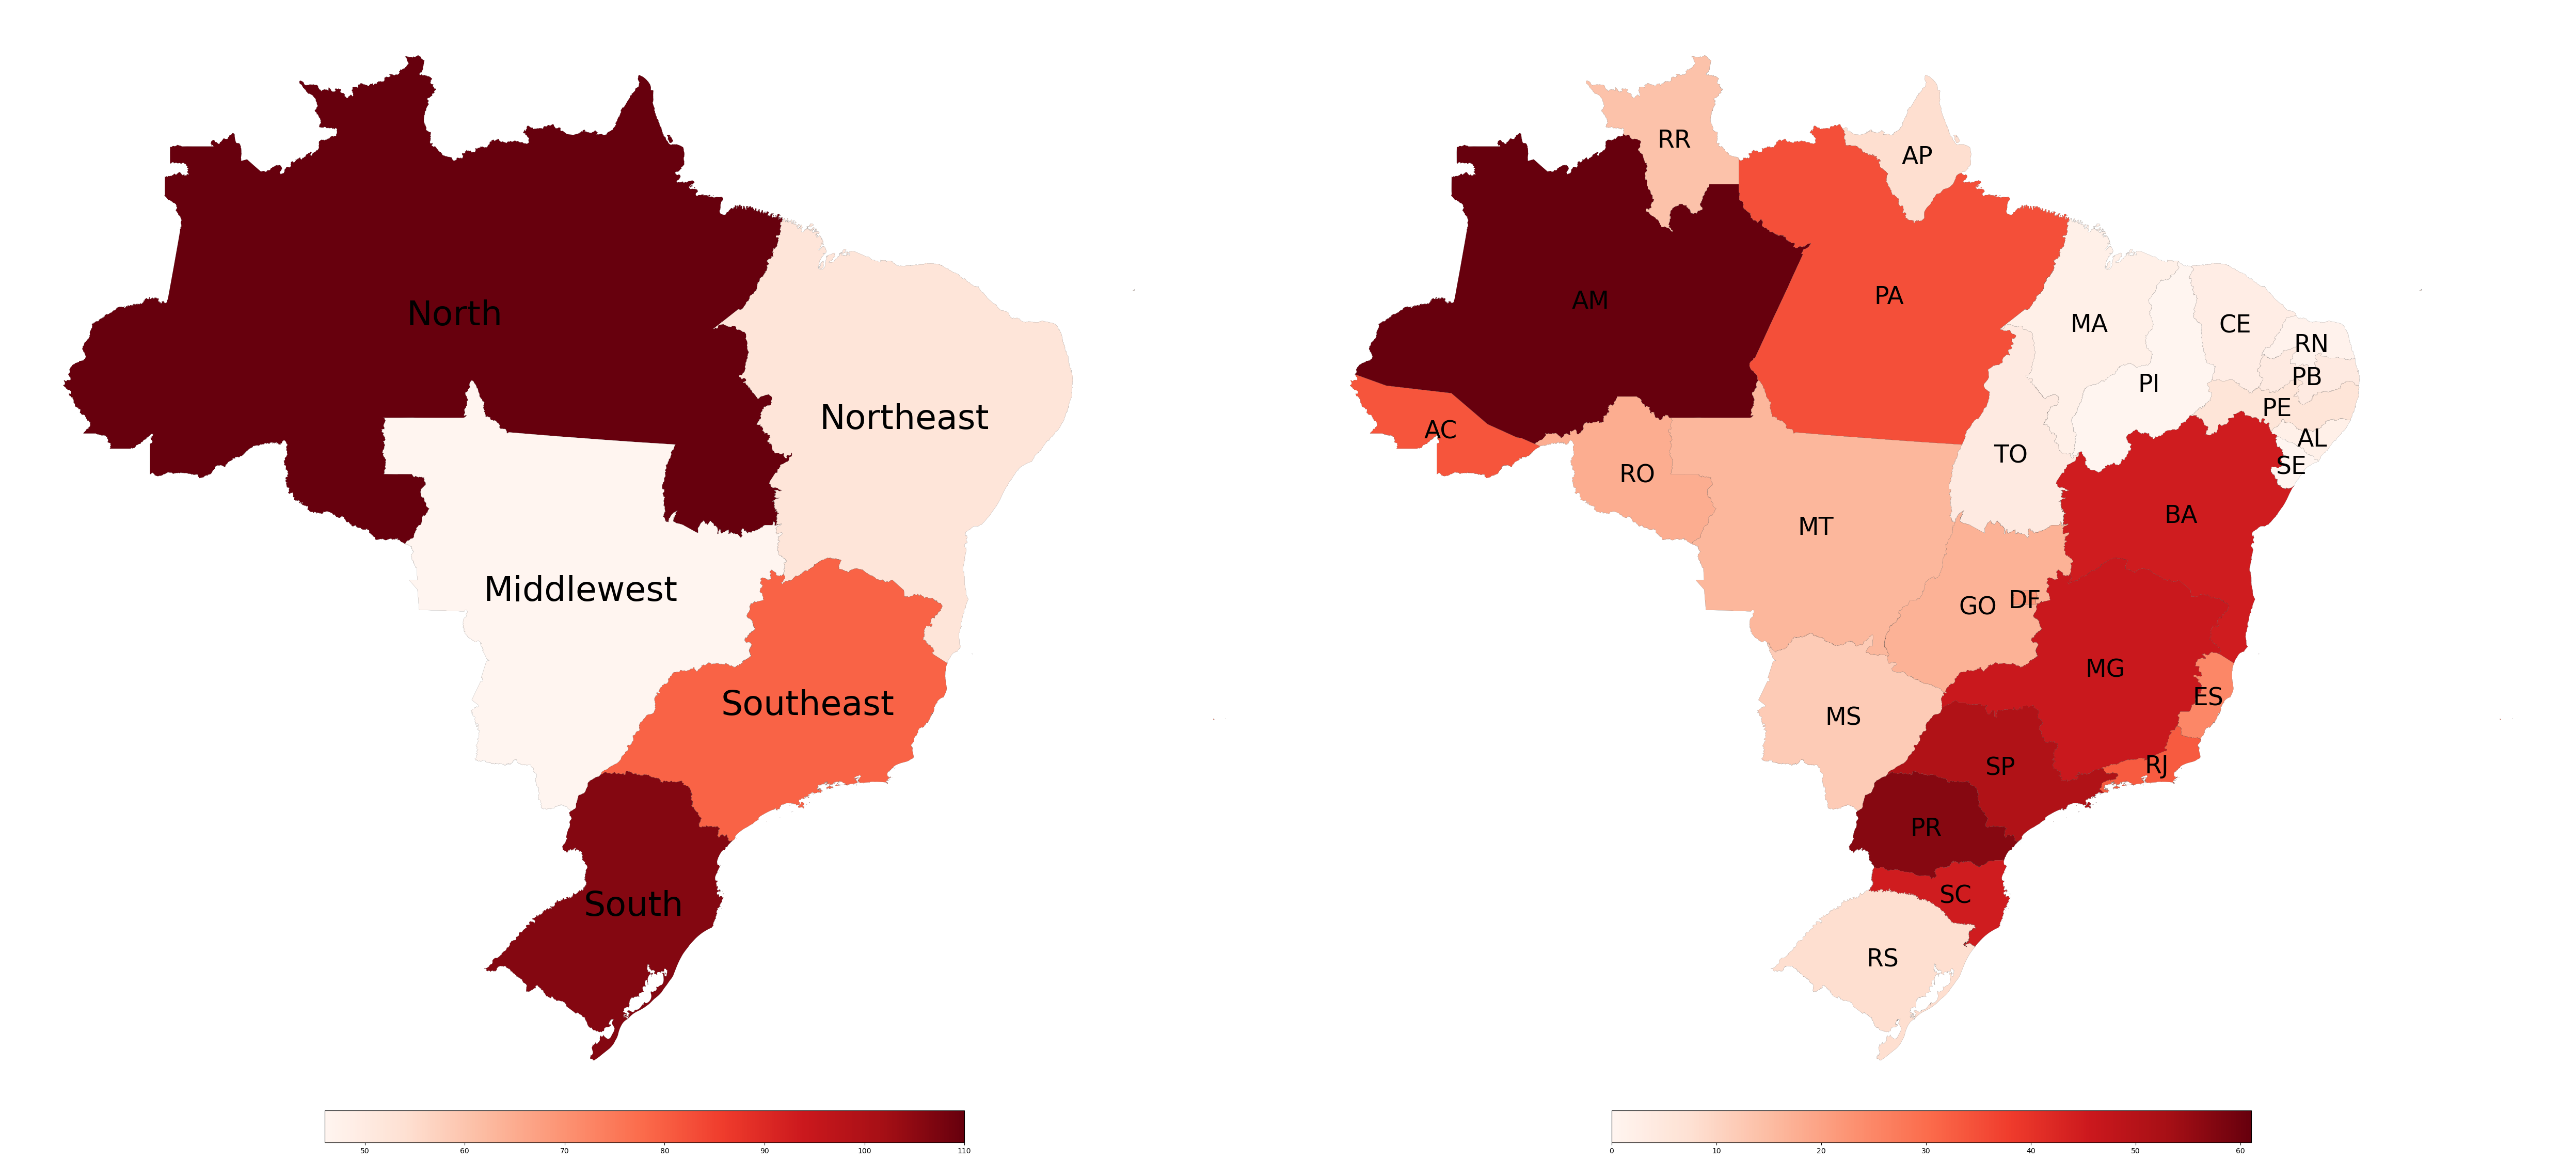

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(50,100))
plt.subplot(1, 2, 1)
regions.plot(column='level', cmap='Reds', legend=True, ax=ax[0],
             linewidth=0.1, edgecolor='0.1',
             legend_kwds={'shrink':0.5, 'orientation': 'horizontal', 'pad': 0.0})
regions.apply(lambda x: ax[0].annotate(text=x['name_region'],
                                       xy=np.subtract(x.geometry.centroid.coords[0], (-0.4, 0.6)),
                                       ha='center', fontsize=48
                                       ), axis=1)
ax[0].set_aspect('equal')
ax[0].axis('off')

plt.subplot(1, 2, 2)
states.plot(column='level', cmap='Reds', legend=True, ax=ax[1],
             linewidth=0.1, edgecolor='0.1',
             legend_kwds={'shrink':0.5, 'orientation': 'horizontal', 'pad': 0.0})
states.apply(lambda x: ax[1].annotate(text=x['abbrev_state'],
                                       xy=np.subtract(x.geometry.centroid.coords[0], (0, 0.4)),
                                       ha='center', fontsize=34), axis=1)
ax[1].set_aspect('equal')
ax[1].axis('off')
plt.tight_layout()

In [12]:
session.close()
engine.dispose()